In [1]:
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

%pip install calmap -q
import calmap

Note: you may need to restart the kernel to use updated packages.


In [2]:
import seaborn as sns

In [3]:
# для красоты графиков (чтобы работало, нужно выполнить import 2 раза, почему так - не знаю)
import seaborn as sns
sns.set(rc={'figure.figsize':(20, 5)})

### Загружаем данные

In [4]:
queues = json.loads(open('data', 'r').read())

def short(name):
    return name.replace('restaurant.queue.', '')

index = 'Time'
columns = []
for q in queues:
    columns.append(short(q['target']))
columns

['far', 'middle', 'near']

In [5]:
data = defaultdict(lambda: {q: {} for q in columns})

for q in queues:
    for dp in q['datapoints']:
        data[dp[1]][short(q['target'])] = dp[0]

data = [(ts, ) + tuple(row[c] for c in columns) for ts, row in data.items()]

In [6]:
df = pd.DataFrame(data, columns=[index] + columns)
df[index] = pd.to_datetime(df[index] + 60 * 60 * 3, unit='s')
df.set_index([index], inplace=True)

### Убираем ненужные даты

2019-04-08 15:30:00


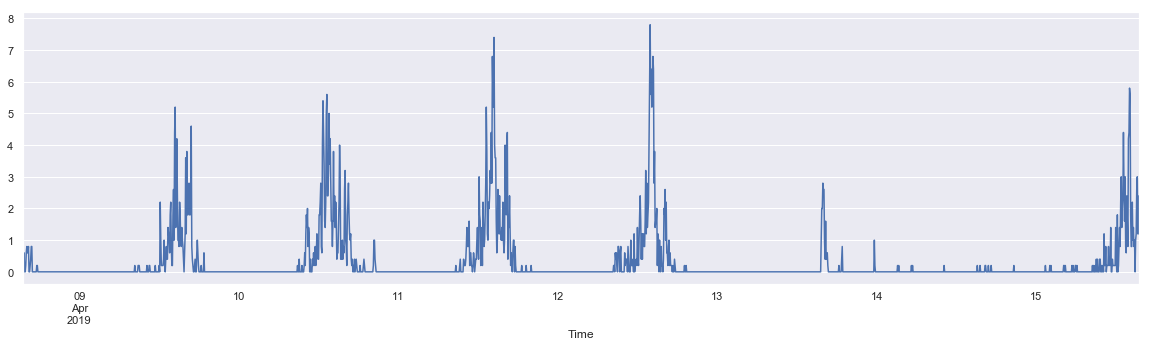

In [7]:
# анализируем данные очереди "TakeAway"
df['middle'].dropna()
first_day = df['middle'].dropna().idxmin()
print(first_day)
df['middle'][first_day:first_day + pd.DateOffset(days=7)].plot()

*Из графика видно, что первый день начинается не с 00:00 + учтем, что еще процесс не до конца налажен, то возьмем следующий день, тем более, что из графиков видно, что у него распределение визуально похоже на последующие дни*

In [8]:
start_time = (first_day + pd.DateOffset(days=1)).floor('d')
df = df[start_time:]

start_time

Timestamp('2019-04-09 00:00:00')

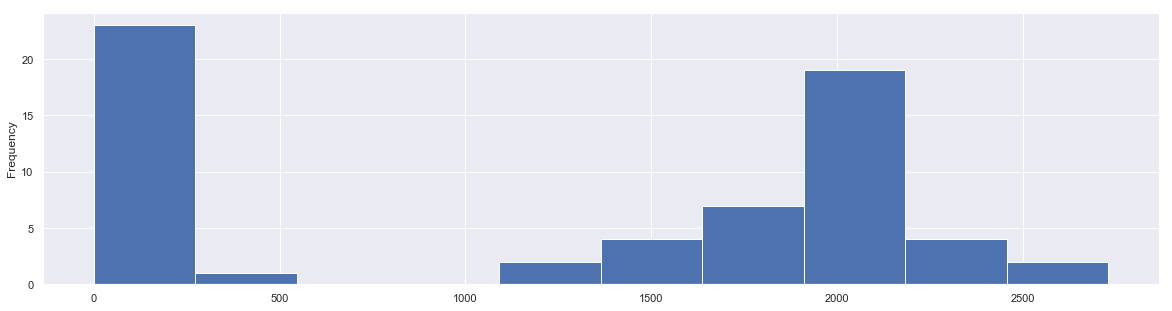

In [9]:
# группируем по дням
grouped = df.groupby([df.index.floor('d')], sort=False).sum(axis=1).sum(axis=1)
grouped.plot.hist()

*Отметка в 1000 разделяет 2 распределения, нас интересует распределение > 1000, когда большая загрузка столовой*

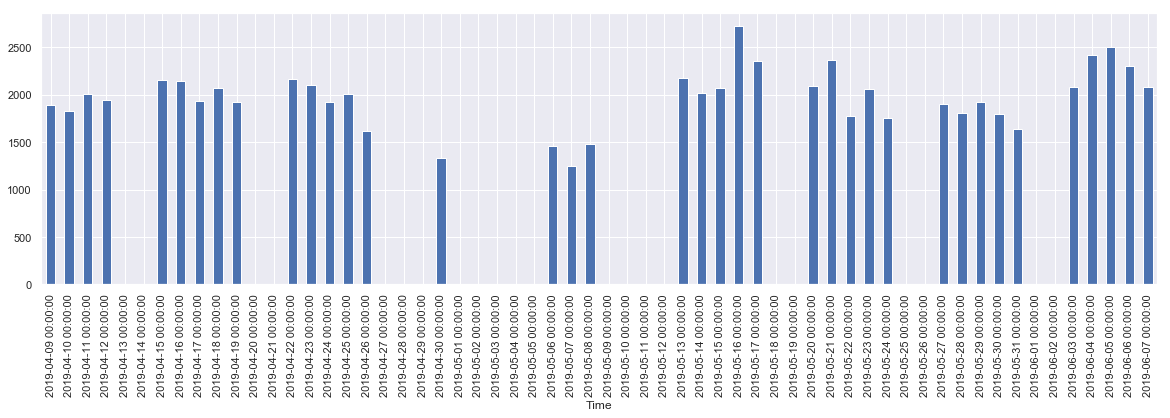

In [10]:
target_days = grouped[grouped > 1000]
target_days.asfreq('d').plot(kind='bar')

*Отметка в 1000 разделяет 2 распределения, нас интересует распределение > 1000, когда большая загрузка столовой*

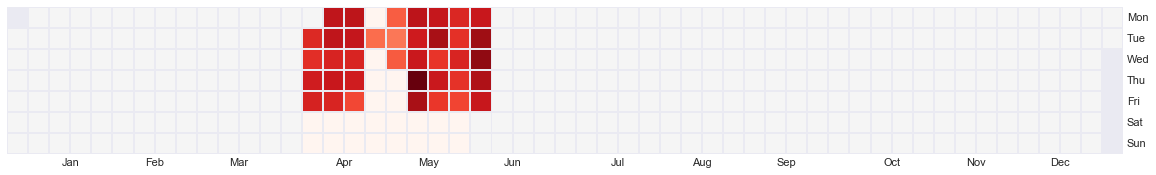

In [11]:
calmap.yearplot(target_days, year=2019)

*На календаре видно, что отфильтрованные дни совпадают с рабочими днями*

In [12]:
# отфильтровываем из основного датасета неинформативные дни
data = df.copy()

data['date'] = data.index.floor('d')
data = data[data.date.isin(target_days.index)]

data = data.between_time('9:00', '18:00')
data.drop('date', axis=1, inplace=True)

### Изучаем данные

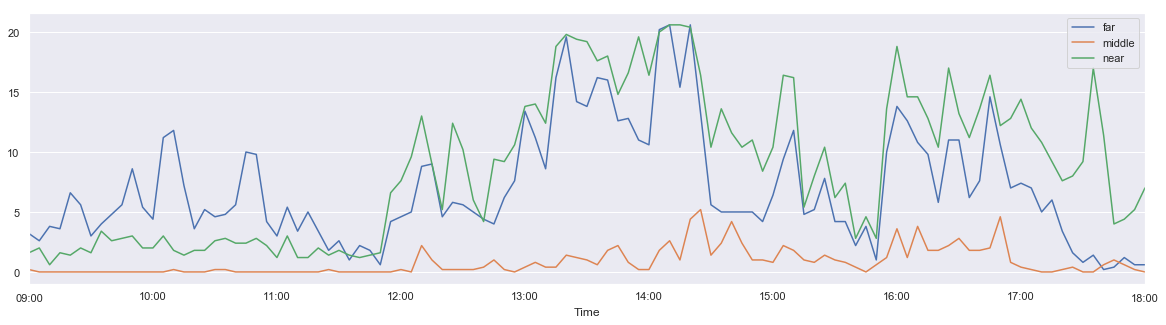

In [13]:
# посмотреть данные за первый день
data[start_time.strftime('%Y-%m-%d')].plot()

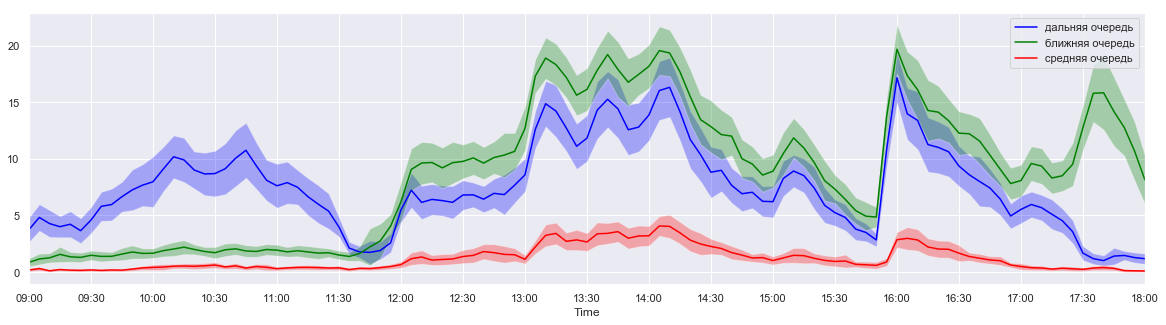

In [14]:
# Но намного интереснее посмотреть агрегированную статистику за все дни
data_agg = data.groupby(
    [data.index.map(lambda d: '{:02d}:{:02d}'.format(d.hour, d.minute))], sort=False
).agg({c: ['mean', 'std'] for c in columns})

xticks = range(0, data_agg.shape[0], data_agg.shape[0] // 18)
plots = (
    ('far', 'дальняя', 'blue'),
    ('near', 'ближняя', 'green'),
    ('middle', 'средняя', 'red'),
)

for line, label, color in plots:
    data_agg[line]['mean'].plot(color=color, xticks=xticks, legend=True, label='{} очередь'.format(label))
    plt.fill_between(
        data_agg.index,
        data_agg[line]['mean'] - data_agg[line]['std'] / 2,
        data_agg[line]['mean'] + data_agg[line]['std'] / 2,
        facecolor=color, alpha=0.3, interpolate=True
    )

Из графика можно сделать следующие выводы:
* В среднем "ближняя" очередь больше "дальней" (Это вполне объясняется тем, что при входе в столовую ты уже почти в "ближней" очереди, а до "дальней" еще нужно идти)
* Есть 4 всплеска чуть позднее 13:00, 13:30, 14:00, 15:00 (Для себя я обосновываю это тем, что мы обычно привязываемся к ровным значениям времени, а отставание всплеска на 5-10 минут от ровного времени - это потраченное время на дорогу к столовой)
* Про резкий всплеск в 16:00 все понятно: все внезапно проголодались :)
* И еще хотелось бы отметить увеличение очереди в 17:30, которое связано с 1) закрытием "дальней очереди" и 2) "в 6 закрывается столовая, нужно успеть поесть"

Собственно, использовав незамысловатую логику, можно посчитать, когда выгоднее ходить в столовую. 

Комментарии:
* агрегированая статистика была взята с момента, когда полноценно работали 3 очереди: "ближняя", "дальняя" и "средняя"
* на графике видно, что до 11:30 не работает "ближняя", а с 17:30 - "дальняя", ненулевые значения, скорее всего - персонал.
* по своему опыту знаю, что количество людей в очереди в часы пик больше, чем максимум графика, т.к. распознавалка не видит всей очереди, поэтому форма пика может быть намного острее, особенно в 16:00.
